## Preprocessing Data and Recording Counts

In [2]:
import numpy as np

symbols = []
with open('symbols.txt') as f:
    for line in f:
        for ch in line:
            if(ch != '\n'):
                symbols.append(ch)

transition_count = np.zeros(shape=(len(symbols), len(symbols))).astype(int)
stationary_count = np.zeros(len(symbols)).astype(int)
prev_ch = '"'
with open('war_peace_text.txt') as f:
    for line in f:
        line = line.rstrip('\n').lower()
        for ch in line:
            if(ch in symbols):
                r = symbols.index(ch)
                stationary_count[r] += 1
                if(prev_ch in symbols):
                    c = symbols.index(prev_ch)
                    transition_count[r, c] += 1
            prev_ch = ch
            

The array transition_probabilities is a 56 x 56 array containing the ML estimates of the probabilities of p(s_1|s_2) where the conditioned symbol is given on the column

In [3]:
print(transition_count)
M = transition_count/transition_count.sum(axis=1, keepdims=True)
P = stationary_count/np.sum(stationary_count)

[[    0     2     0 ...     0     0     0]
 [    2 13174  1973 ...   226 23265    71]
 [    0    11     1 ...     9   291     6]
 ...
 [    0   235     0 ...    79     0     0]
 [    0  5604    32 ...     4    16    14]
 [    0   130    12 ...     0    11    47]]


In [4]:
print(M)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.73057072e-06 2.45732693e-02 3.68020802e-03 ... 4.21554492e-04
  4.33958639e-02 1.32435261e-04]
 [0.00000000e+00 2.84974093e-03 2.59067358e-04 ... 2.33160622e-03
  7.53886010e-02 1.55440415e-03]
 ...
 [0.00000000e+00 5.82837302e-02 0.00000000e+00 ... 1.95932540e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.22006444e-01 6.96682052e-04 ... 8.70852565e-05
  3.48341026e-04 3.04798398e-04]
 [0.00000000e+00 5.44616674e-02 5.02723083e-03 ... 0.00000000e+00
  4.60829493e-03 1.96899874e-02]]


In [7]:
transition_count_2 = np.zeros(shape=(len(symbols), len(symbols))).astype(int)
stationary_count_2 = np.zeros(len(symbols)).astype(int)
prev_ch = '"'
with open('war_peace_text.txt') as f:
    for line in f:
        line = line.rstrip('\n').lower()
        for ch in line:
            if(ch in symbols):
                r = symbols.index(ch)
                stationary_count_2[r] += 1
                if(prev_ch in symbols):
                    c = symbols.index(prev_ch)
                    transition_count_2[r, c] += 1
            prev_ch = ch

In [8]:
transition_count_2 += 1
M_2 = transition_count_2/transition_count_2.sum(axis=1, keepdims=True)
P_2 = stationary_count_2/np.sum(stationary_count_2)

In [9]:
import matplotlib.pyplot as plt
import random
random.seed(5)
np.random.seed(5)

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

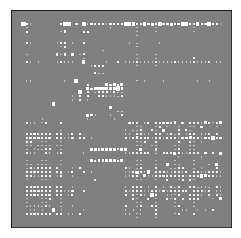

In [10]:
hinton(M)

In [11]:
import pylab as Py

def _blob(x,y,area,colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    Py.fill(xcorners, ycorners, colour, edgecolor=colour)

def hinton_2(W, maxWeight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix. 
    Temporarily disables matplotlib interactive mode if it is on, 
    otherwise this takes forever.
    """
    reenable = False
    if Py.isinteractive():
        Py.ioff()
    Py.clf()
    height, width = W.shape
    if not maxWeight:
        maxWeight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))

    Py.fill(np.array([0,width,width,0]),np.array([0,0,height,height]),'gray')
    Py.axis('off')
    Py.axis('equal')
    for x in range(width):
        for y in range(height):
            _x = x+1
            _y = y+1
            w = W[y,x]
            if w > 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,w/maxWeight),'white')
            elif w < 0:
                _blob(_x - 0.5, height - _y + 0.5, min(1,-w/maxWeight),'black')
    if reenable:
        Py.ion()
    Py.show()

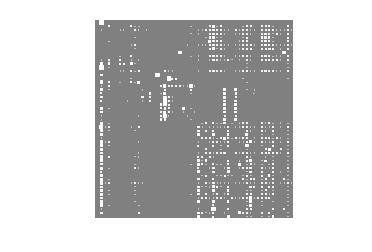

In [12]:
hinton_2(M)

<BarContainer object of 53 artists>

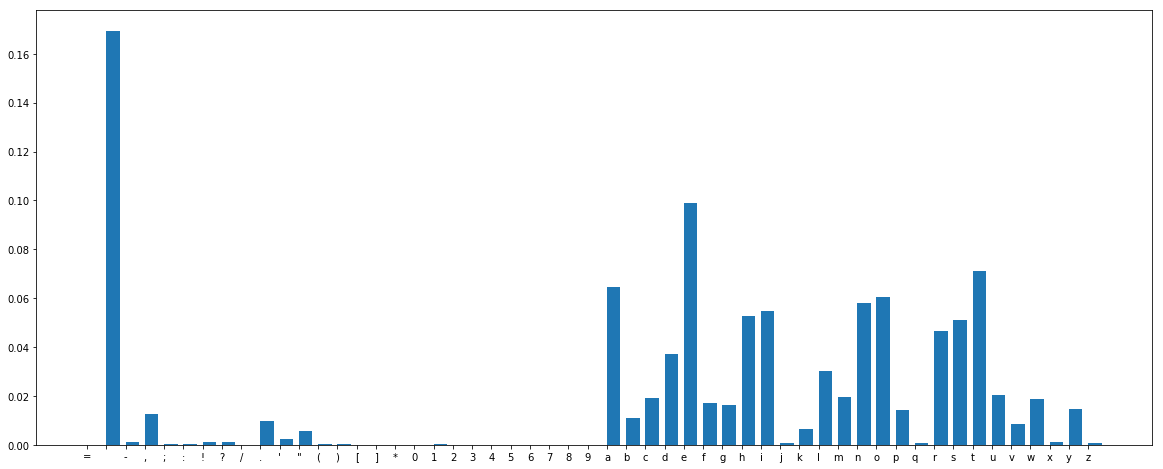

In [13]:
plt.figure(figsize=(20, 8))
plt.bar(symbols,P, align='edge', width=0.7)

### Defining MCMC for text class object
### Note that f/sigma^-1 is just a function that provides a one to one mapping between the symbols.

In [12]:
symbol_length = len(symbols)
cipher_text = None
with open('message.txt') as f:
    cipher_text = [line.strip() for line in f]
cipher_text = cipher_text[0]

cipher_text_2 = None
with open('untitled.txt') as f:
    cipher_text_2 = [line.strip() for line in f]
cipher_text_2 = cipher_text_2[0]

In [13]:
import copy

class MCMC(object):
    
    def __init__(self, M, P, symbol_length, cipher_text, symbols):
        """
        --M is the transition probability matrix
        --P is the invariant stationary matrix
        --symbol_length is the number of symbols in the alphabet
        --cipher_text is the encypted text we wish to decrypt
        --f is the current inverse sigma (permutation) function
        --cipher_ints is the equivalent representation of the symbols
          in terms of integers {0,1,..,54}
        """
        self.M = M
        self.P = P
        self.symbol_length = symbol_length
        self.cipher_text = cipher_text
        self.f = np.random.choice(symbol_length, symbol_length, replace=False).astype(int)
        self.cipher_ints = np.zeros(len(cipher_text)).astype(int)
        self.symbol_list = symbols

    def m_h_step(self):
        """
        Performs the Metropolis-Hastings update step:
        1. A proposal function test_f is generated
        2. The scores p(e|f) for the proposal (f_test) and current 
           (self.f) permutations are computed.
        3. The MH acceptance probability is computed.
        4. The current permutation function is copied through or 
           replaced by test_f for the next step via rejection sampling.
        """
        index_1 = random.randint(0, self.symbol_length-1)
        index_2 = random.randint(0, self.symbol_length-1)
        test_f = self.sample_f(index_1, index_2)
        
        score_1, pred_1 = self.score(self.f)
        score_2, pred_2 = self.score(test_f)
        A = np.minimum(1, np.exp(score_2 - score_1))
        
        if(np.random.uniform() <= A):
            
            self.f[index_1] = np.take(test_f, index_1)
            self.f[index_2] = np.take(test_f, index_2)
        
        pass

    def sample_f(self, index_1, index_2):
        """
        Function to randomly sample a proposal permutation 
        by swapping the two symbols (represented by integers) 
        at index_1 and index_2 in the current permutation function.
        --test_f is the proposal
        """
        
        test_f = np.zeros(self.symbol_length).astype(int)
        
        for i in range(self.symbol_length):
            if(i == index_1):
                test_f[i] = np.take(self.f, index_2)
            elif(i == index_2):
                test_f[i] = np.take(self.f, index_1)
            else:
                test_f[i] = np.take(self.f, i)
        
        return test_f
    
    def initialise_f(self):
        """
        Function to intitialse f 'cleverly'. After randomly 
        intialising f, certain values of f(e) = s are instantiated. 
        For example, in our encyption, we want 'p' in the encyption 
        to map to '<space>' in the decrpytion.
        """
        
        ### p symbol 42 stand for <space> 1
        self.swap_char_map('p', ' ')
#        self.swap_char_map('[', 'i')
#        self.swap_char_map(':', 'n')
#        self.swap_char_map('w', 'a')
        
        pass
    
    def swap_char_map(self, ch, ch_new):
        """
        Forces the permutation function f to map the encypted 
        symbol 'ch' to the decrpyted symbol 'ch_new'.
        """
        val_char_to_swap = self.symbol_list.index(ch)
        val_char_to_place = self.symbol_list.index(ch_new)
        
        value_in_old_f = np.take(self.f, val_char_to_swap)
        index_to_swap = np.where(self.f == val_char_to_place)
       
        self.f[val_char_to_swap] = val_char_to_place
        self.f[index_to_swap] = value_in_old_f
        
        pass
    
    def generate_string_representation(self):
        """
        Generates a string representation of the decryption 
        of the string.
        """
        str_rep = ""
        for i in self.cipher_ints:
            index_of_symbol = self.f[i]
            string_of_symbol = self.symbol_list[index_of_symbol]
            str_rep += string_of_symbol
        
        return str_rep
        
    def score(self, f):
        """
        Score function to compute the value of p(e|f) using 
        the transition matrix M, stationary probabilities P
        and the formulae derived in the question.
        """
        j = 0
        prediction = np.zeros(len(cipher_text)).astype(int)
        for i in self.cipher_ints:
            prediction[j] = np.take(f, i)
            j += 1
            
        total_score = np.log(self.P[prediction[0]])
        for i in range(1, np.size(prediction)):
            total_score += np.log(self.M[prediction[i]][prediction[i-1]])
            
        return total_score, prediction
            
    def create_cipher_numbering(self):
        """
        Creates an integer representation of the encypted text by using substituting each symbol with the map:
        {'=', ' ', ...,'z'} -> {0, 1, ..., 54}
        """
        i = 0
        for ch in self.cipher_text:
            self.cipher_ints[i] = self.symbol_list.index(ch)
            i += 1
        
        pass

In [14]:
final = [[]]*10
for t in range(1):
    metroMCMC = MCMC(M, P, symbol_length, cipher_text, symbols)
    metroMCMC.create_cipher_numbering()
    metroMCMC.initialise_f()
    for i in range(15000):
        c = metroMCMC.m_h_step()
        if(i%100==0):
            x = metroMCMC.generate_string_representation()[0:62]
            final[t].append(x)
            print(x)
        
            

;t y] ]2utmfh lt? y2hf (ustfhlzsf ]flhd y] !lj0fh ml(f yf d2yf
;e "o owuemfh ge, "whf pusefhgasf ofghr "o ignyfh mgpf "f rw"f
;e "o owuemit ge, "wti puseitgrsi oigta "o fgnyit mgpi "i aw"i
;e ho oryegit me, hrti pyseitmwsi oimta ho nmfuit gmpi hi arhi
pe ho orye;it me, hrti "yseitmwsi oimta ho dmfuit ;m"i hi arhi
pe ho orye,is men hrsi "yfeismwfi oimsa ho dmtuis ,m"i hi arhi
pe ha arye,is men hrsi kyfeismwfi aimso ha dmtuis ,mki hi orhi
pi ha aryiges min hrse kyfiesmwfe aemso ha dmtues gmke he orhe
pi ha aryiges min hrse kyfiesmwfe aemso ha dmtues gmke he orhe
pi ha aryiges min hrse kyfiesmlfe aemso ha dmtues gmke he orhe
pi ht tryiges min hrse kyoiesmloe temsf ht dmaues gmke he frhe
ui ht tryiges min hrse kyoiesmboe temsf ht dmapes gmke he frhe
im ht trymges omn hrse kyumesobue teosf ht doaces goke he frhe
im ht tuymwes omn huse kyrmesobre teosf ht doaces woke he fuhe
an ht tuknyes onf huse wkrnesobre teosm ht doices yowe he muhe
an ht tuknyes onf huse wkrnesobre teosm ht doices yowe 

In [87]:
print(len(final[0]))

63


In [55]:
x = 'in r5 5*kne:. an! r*.: ok4n:.a,4: 5:a.x r5 ?ajw:. eao: r: x*r:', 'in r5 5xpn-ge any rxeg ophngeawhg 5gaes r5 uav*ge -aog rg sxrg', 'in r? ?lpn-ed anv rlde upwneda6we ?eads r? oaybed -aue re slre', 'in r? ?lpn-ed anu rlde vpwnedazwe ?eads r? oaybed -ave re slre', 'on r, ,lun-ew anp rlwe hudnewazde ,eaws r, iatbew -ahe re slre', 'on r, ,lunked ang rlde huwnedazwe ,eads r, iatbed kahe re slre', 'on r, ,lunked ang rlde huwnedazwe ,eads r, iatbed kahe re slre', 'on r, ,lunked ang rlde huwnedazwe ,eads r, iatyed kahe re slre', 'on r, ,lunved ang rlde hupnedazpe ,eads r, iatyed vahe re slre', 'on r, ,lunved ang rlde hufnedazfe ,eads r, iatyed vahe re slre', 'on r, ,lunved ang rlde hufnedazfe ,eads r, iatyed vahe re slre', 'on r, ,lunved ang rlde hufnedazfe ,eads r, iatyed vahe re slre', 'on r, ,iunved ang ride hufnedazfe ,eads r, latyed vahe re sire', 'on r, ,iunved ang ride hufnedapfe ,eads r, latwed vahe re sire', 'on r, ,iunked ang ride hufnedapfe ,eads r, latwed kahe re sire', 'on r, ,iunked ang ride hulnedaple ,eads r, fatwed kahe re sire', 'on r, ,iunyed ang ride hulnedaple ,eads r, fatwed yahe re sire', 'on r, ,iunyed ang ride hulnedaple ,eads r, fatwed yahe re sire', 'on r, ,iunyed ang ride hulnedaple ,eads r, matwed yahe re sire', 'on r, ,iunyed ang ride hulnedaple ,eads r, matwed yahe re sire', 'on r, ,iunyed ang ride hulnedaple ,eads r, matwed yahe re sire', 'on d, ,iunyer ang dire hulneraple ,ears d, matwer yahe de side', 'on g, ,iunyer and gire hulneraple ,ears g, matwer yahe ge sige', 'on g, ,iunyer and gire hulneraple ,ears g, matwer yahe ge sige', 'on g, ,iunyer and gire hulneraple ,ears g, matwer yahe ge sige', 'on g, ,iunyer and gire hulneraple ,ears g, matwer yahe ge sige', 'in m, ,ounyer and more hulneraple ,ears m, gatwer yahe me some', 'in m, ,ounyer and more hulneraple ,ears m, gatwer yahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more hulneraple years my gatwer ,ahe me some', 'in my youn,er and more zulneraple years my gatwer ,aze me some', 'in my youncer and more zulneraple years my gatwer caze me some', 'in my youncer and more vulneraple years my gatwer cave me some', 'in my youncer and more vulneraple years my gatwer cave me some', 'in my youncer and more vulneraple years my father cave me some', 'in my youncer and more vulneraple years my father cave me some', 'in my youncer and more vulneraple years my father cave me some', 'in my youncer and more vulneraple years my father cave me some', 'in my younger and more vulneraple years my father gave me some', 'in my younger and more vulneraple years my father gave me some', 'in my younger and more vulneraple years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some', 'in my younger and more vulnerable years my father gave me some'

In [91]:
x = final[0][0:44]

In [92]:
import pandas as pd 
pd.options.display.max_colwidth = 100
df = pd.DataFrame(x, columns=['Decrypted String'])

In [93]:
display(df)

,Decrypted String
0,5* qy y](*8e' ;*k q]'e 9(s*e';?se ye;'d qy =;t[e' 8;9e qe d]qe
1,vn *g g]unse' fnk *]'e iulne'f4le gef'd *g aft.e' sfie *e d]*e
2,ma g; ;suayer fak gsre iulaerf4le ;efrd g; nft.er yfie ge dsge
3,yu g; ;sfumer auk gsre ifluera'le ;eard g; natver maie ge dsge
4,ou w; ;shumer auk wsre bhluera-le ;eard w; natcer mabe we dswe
5,ou w. .ihumer auk wire bhluera-le .ears w. natcer mabe we siwe
6,ou w. .ihumer auk wire bhluera-le .ears w. natcer mabe we siwe
7,ou w. .ikumer aug wire dkluera-le .ears w. natcer made we siwe
8,ou w. .ikumer aug wire dklueravle .ears w. natcer made we siwe
9,ou w. .ikumer aun wire dklueragle .ears w. vather made we siwe


In [ ]:
df.to_latex(index=False)

In [95]:
import matplotlib.pyplot as plt
import six

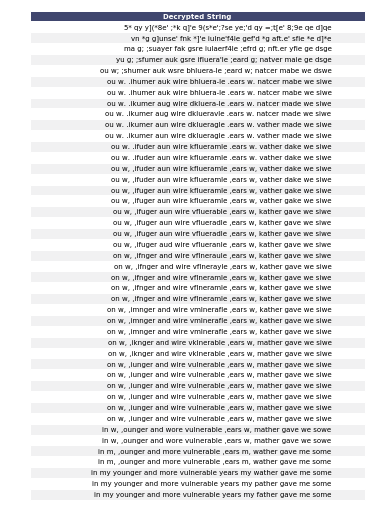

In [96]:
def render_mpl_table(data, col_width=200.0, row_height=0.2, font_size=7,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df, header_columns=0, col_width=6.0)

In [ ]:
df.to_latex()